## Встановлення пакетів

In [69]:
# %pip install numpy==1.26.4 tensorflow seaborn matplotlib optuna
# %pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


## Імпорт пакетів

In [76]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader, ConcatDataset
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
torch.backends.cudnn.benchmark = True
import os
import random
from collections import defaultdict
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import optuna

## Підготовка датасету

In [48]:
path = 'Formula One Cars'

transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

augmentation_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=[-30, 30])
    ], p=0.7),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_dataset = datasets.ImageFolder(root=path, transform=transform)

train_val_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_val_size
train_val_dataset, test_dataset = random_split(full_dataset, [train_val_size, test_size])

train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

augmented_full_dataset = datasets.ImageFolder(root=path, transform=augmentation_transform)
train_dataset = ConcatDataset([train_dataset, augmented_full_dataset])

train_loader = DataLoader(train_dataset, batch_size=128, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, pin_memory=True, shuffle=False)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

Train samples: 2882
Val samples: 134
Test samples: 336


## Візуалізація зображень з датасету

C:\Users\bogda\miniconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


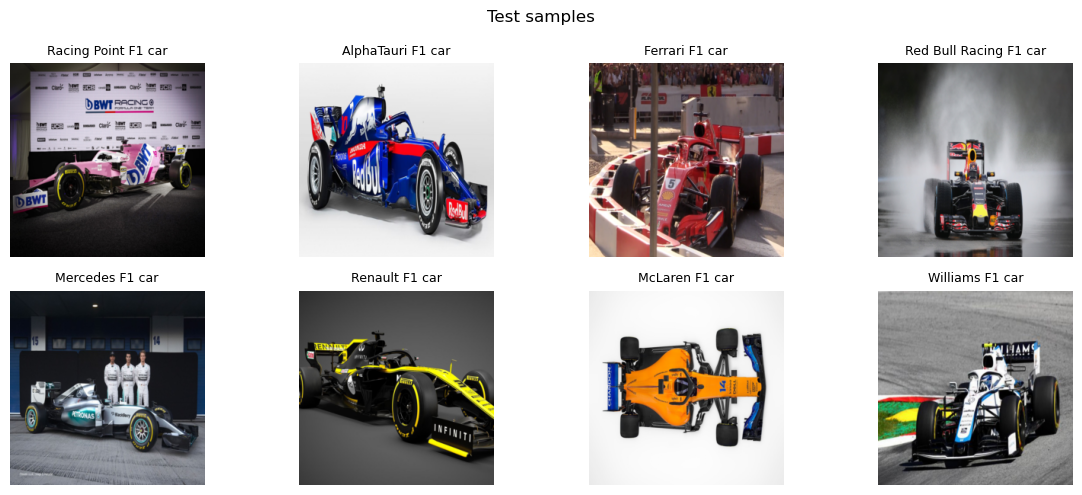

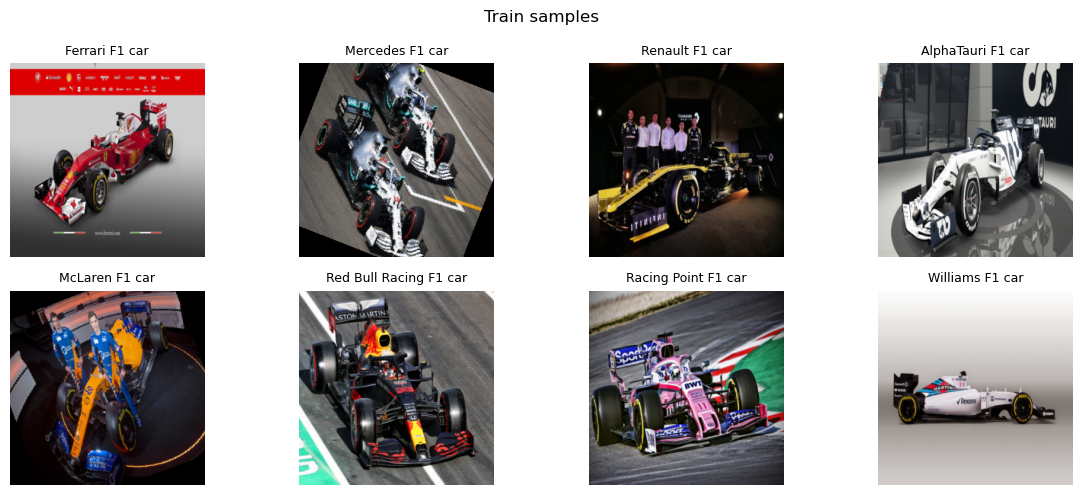

In [49]:
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5
    return tensor

def plot_image(img, title, index, total_rows, total_cols):
    plt.subplot(total_rows, total_cols, index)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(title, fontsize=9)
    plt.axis('off')
    
def collect_class_samples(loader, class_names, samples_per_class):
    seen = {cls: 0 for cls in class_names}
    collected = []
    for images, labels in loader:
        for img, label in zip(images, labels):
            class_idx = label.item()
            class_name = class_names[class_idx]
            if seen[class_name] < samples_per_class:
                collected.append((img, class_name))
                seen[class_name] += 1
            if all(count >= samples_per_class for count in seen.values()):
                return collected
    return collected

def show_samples_from_loader(loader, class_names, samples_per_class=2, title = None):
    samples = collect_class_samples(loader, class_names, samples_per_class)
    rows = 2
    cols = (len(samples) + 1) // 2

    plt.figure(figsize=(cols * 3, rows * 2.5))
    
    if title:
        plt.suptitle(title)
    
    for i, (img, title) in enumerate(samples, 1):
        img = denormalize(img).numpy()
        plot_image(img, title, i, rows, cols)
    plt.tight_layout()
    
    plt.show()
    

show_samples_from_loader(test_loader, full_dataset.classes, 1, "Test samples")
show_samples_from_loader(train_loader, full_dataset.classes, 1, "Train samples")

## Кількість зображень на клас

Було проведено ручне очищення датасету: видалено нерелевантні зображення (наприклад фото мерча команд, або ж боліди до сезону 2013) та зображення, які були не відповідали своїм класам.
У результаті датасет зменшився більш ніж на чверть

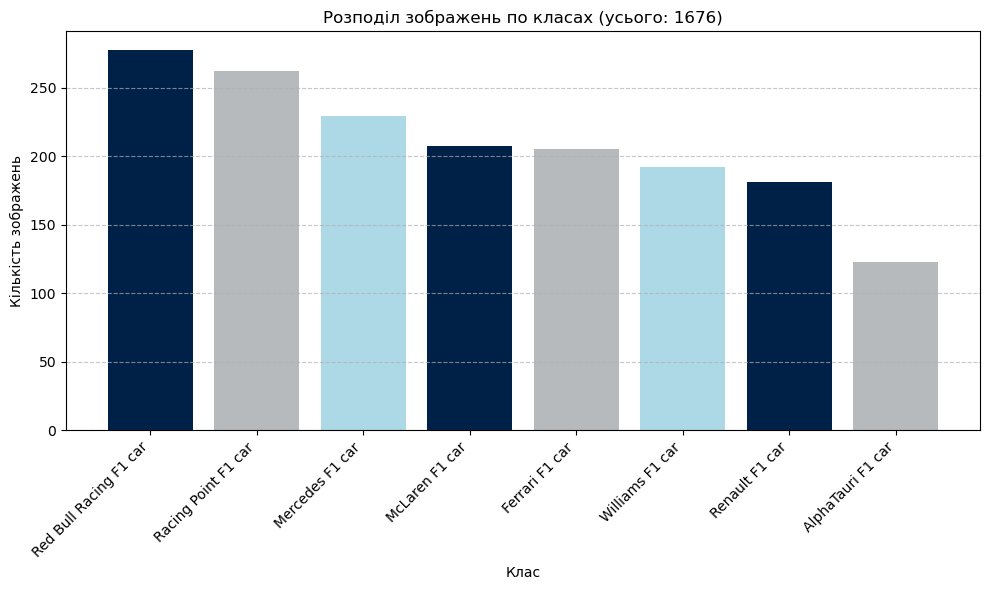

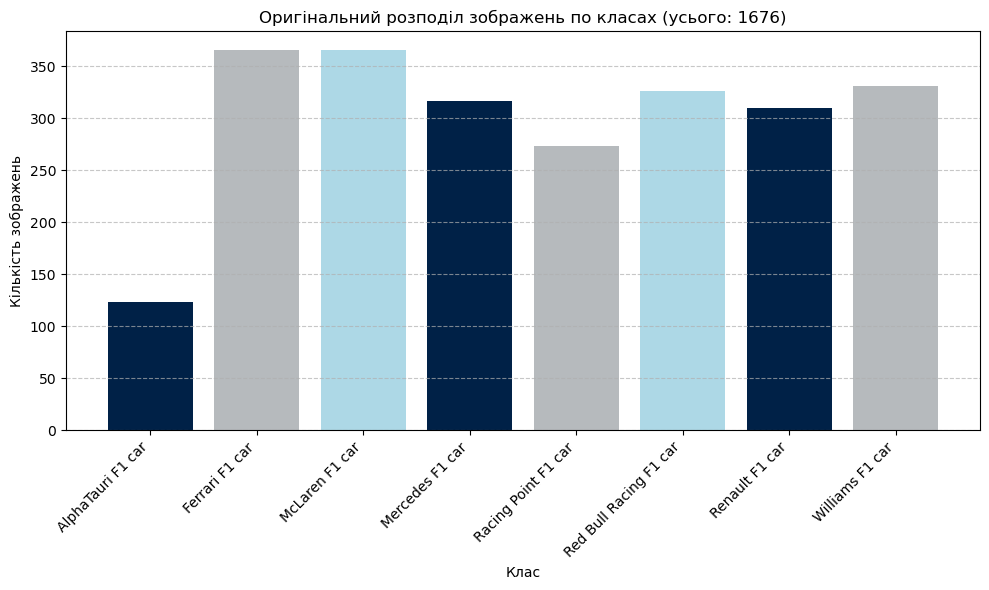

In [50]:
label_indices = full_dataset.targets
label_counts = Counter(label_indices)
idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}
sorted_items = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
class_names = [idx_to_class[idx] for idx, _ in sorted_items]
image_counts = [count for _, count in sorted_items]
total_images = sum(image_counts)

colors = [
    "#002147",
    "#B6BABD",
    "#ADD8E6"
]

plt.figure(figsize=(10, 6))
plt.bar(class_names, image_counts, color=colors)
plt.xlabel("Клас")
plt.ylabel("Кількість зображень")
plt.title(f"Розподіл зображень по класах (усього: {total_images})")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# оригінальний датасет
old_dataset_path = "Formula One Cars - original"
original_dataset = datasets.ImageFolder(old_dataset_path)

original_label_indices = original_dataset.targets
original_label_counts = Counter(original_label_indices)
class_names = [k for k, _ in original_dataset.class_to_idx.items()]
original_image_counts = [original_label_counts[original_dataset.class_to_idx[class_name]] for class_name in class_names]
original_total_images = sum(image_counts)

plt.figure(figsize=(10, 6))
plt.bar(class_names, original_image_counts, color=colors)
plt.xlabel("Клас")
plt.ylabel("Кількість зображень")
plt.title(f"Оригінальний розподіл зображень по класах (усього: {original_total_images})")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Клас згорткової нейронної мережі

In [77]:
class CnnF1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 32 * 128, 256)
        self.fc2 = nn.Linear(256, 8)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, save_path="cnn_f1.pt"):
    train_acc_history, train_loss_history, val_acc_history, val_loss_history = [], [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = train_correct / total
        train_loss_history.append(train_loss / len(train_loader))
        train_acc_history.append(train_acc)

        model.eval()
        val_loss, val_correct, total = 0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_acc = val_correct / total
        val_loss_history.append(val_loss / len(val_loader))
        val_acc_history.append(val_acc)
        print(f"\nЕпоха: {epoch+1}/{epochs}")
        
    torch.save(model.state_dict(), save_path)
    print(f"\nМодель збережено: {save_path}")
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

def plot_metrics(train_loss, val_loss, train_acc, val_acc):
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Тренувальна точність")
    plt.plot(val_acc, label="Валідаційна точність")
    plt.title("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Тренувальні втрати")
    plt.plot(val_loss, label="Валідаційні втрати")
    plt.title("Loss")
    plt.legend()


## Тренування моделі
> **(оптимальна модель буде у комірці нижче. ця комірка була створена під час виконання задачі №2)**


Епоха: 1/50

Епоха: 2/50

Епоха: 3/50

Епоха: 4/50

Епоха: 5/50

Епоха: 6/50

Епоха: 7/50

Епоха: 8/50

Епоха: 9/50

Епоха: 10/50

Епоха: 11/50

Епоха: 12/50

Епоха: 13/50

Епоха: 14/50

Епоха: 15/50

Епоха: 16/50

Епоха: 17/50

Епоха: 18/50

Епоха: 19/50

Епоха: 20/50

Епоха: 21/50

Епоха: 22/50

Епоха: 23/50

Епоха: 24/50

Епоха: 25/50

Епоха: 26/50

Епоха: 27/50

Епоха: 28/50

Епоха: 29/50

Епоха: 30/50

Епоха: 31/50

Епоха: 32/50

Епоха: 33/50

Епоха: 34/50

Епоха: 35/50

Епоха: 36/50

Епоха: 37/50

Епоха: 38/50

Епоха: 39/50

Епоха: 40/50

Епоха: 41/50

Епоха: 42/50

Епоха: 43/50

Епоха: 44/50

Епоха: 45/50

Епоха: 46/50

Епоха: 47/50

Епоха: 48/50

Епоха: 49/50

Епоха: 50/50

Модель збережено: cnn_f1.pt


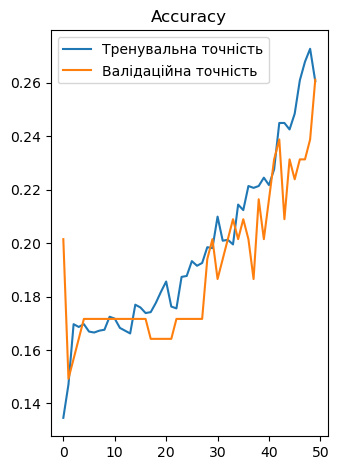

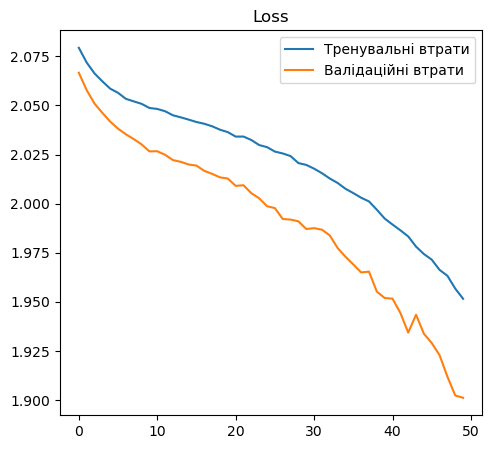

In [15]:
device = torch.device('cuda')

model = CnnF1().to(device)

epochs = 50
batch_size = 128
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loss, val_loss, train_acc, val_acc = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs
)

plot_metrics(train_loss, val_loss, train_acc, val_acc)

## Обрахування метрик

Порівняння моделей на 10, 25 та 50 епох

> **(оптимальна модель буде у комірці нижче. ця комірка була створена під час виконання задачі №2)**

In [52]:
def evaluate_model(model_path, model_class, val_loader, device):
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    y_true = np.array(all_labels)
    y_pred = np.array(all_predictions)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')

    return acc, f1

model_dir = "trained-models"
model_files = [f for f in os.listdir(model_dir) if f.endswith(".pt")]

results = []

for model_file in model_files:
    model_path = os.path.join(model_dir, model_file)
    acc, f1 = evaluate_model(model_path, CnnF1, val_loader, device)
    results.append((model_file, acc, f1))
    print("\n" + model_file)
    print(f"Точність: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")



cnn_f1_10epochs.pt
Точність: 0.1940
F1 Score: 0.0788

cnn_f1_25epochs.pt
Точність: 0.1716
F1 Score: 0.0538

cnn_f1_50epochs.pt
Точність: 0.2463
F1 Score: 0.1888


In [74]:
def plot_prediction(img, truth, prediction, index, total_rows, total_cols):
    color = "green" if truth == prediction else "red"
    
    plt.subplot(total_rows, total_cols, index)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(truth, fontsize=9)
    plt.axis('off')
    plt.text(0.5, -0.3, f"Передбачення: {prediction}", fontsize=9, color=color)

def collect_one_sample_per_class(loader, class_names, device):
    class_to_images = defaultdict(list)

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        for img, label in zip(images, labels):
            class_idx = label.item()
            class_name = class_names[class_idx]
            class_to_images[class_name].append((img, label))
        
        if all(len(class_to_images[cls]) > 0 for cls in class_names):
            break

    selected_samples = []
    for class_name in class_names:
        samples = class_to_images[class_name]
        if samples:
            selected_samples.append(random.choice(samples))

    return selected_samples

def show_predictions(model, loader, class_names, device, title=None):
    model.eval()
    samples = collect_one_sample_per_class(loader, class_names, device)
    rows = 2
    cols = (len(samples) + 1) // 2

    plt.figure(figsize=(cols * 3, rows * 3))

    if title:
        plt.suptitle(title, fontsize=14)

    with torch.no_grad():
        for i, (img, label) in enumerate(samples, 1):
            input_img = img.unsqueeze(0).to(device)
            output = model(input_img)
            _, pred = torch.max(output, 1)

            truth_class = class_names[label.item()]
            predicted_class = class_names[pred.item()]
            
            img_np = denormalize(img.cpu()).numpy()
            plot_prediction(img_np, truth_class, predicted_class, i, rows, cols)

    plt.tight_layout()
    plt.show()

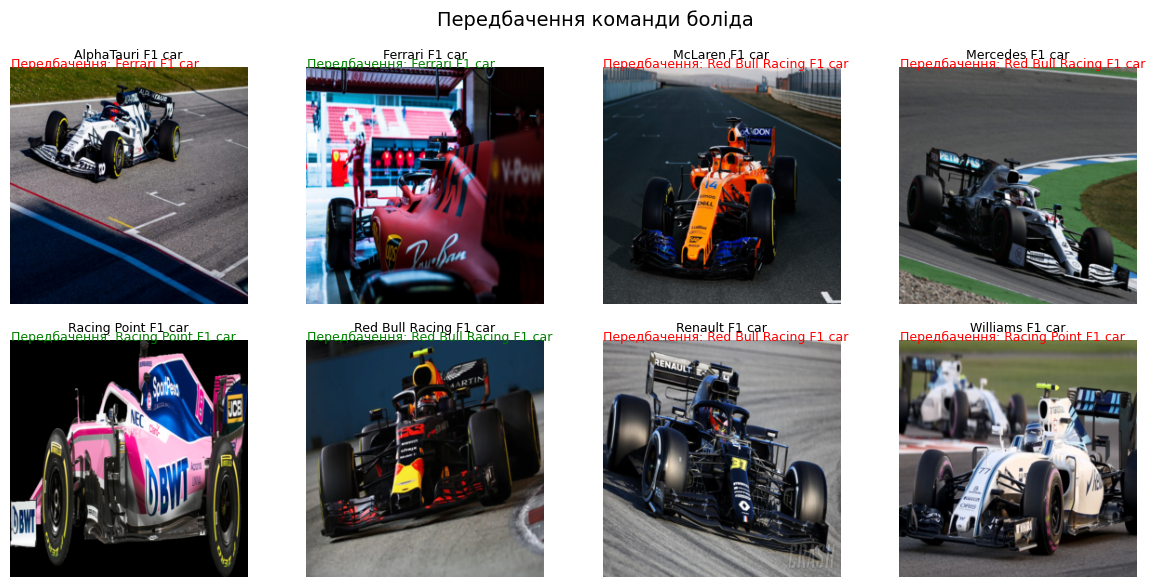

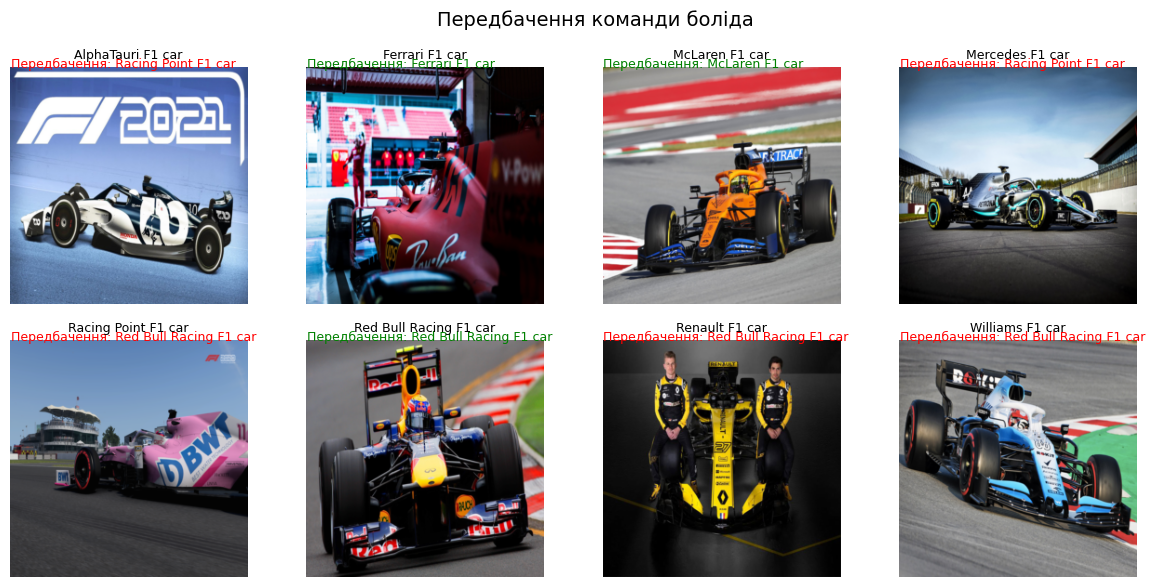

In [39]:
model.load_state_dict(torch.load("trained-models/cnn_f1_50epochs.pt"))
model.to(device)

show_predictions(model, test_loader, full_dataset.classes, device, title="Передбачення команди боліда")
show_predictions(model, test_loader, full_dataset.classes, device, title="Передбачення команди боліда")


## Автоматизована оптимізація

In [55]:
def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    
    model = CnnF1().to(device)
    
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name == "RMSprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

    criterion = nn.CrossEntropyLoss()
    save_name = f"cnn_f1_optuna_{optimizer_name}_lr{lr:.1e}.pt"

    train_loss, val_loss, train_acc, val_acc = train_model(
        model, train_loader, val_loader, criterion, optimizer,
        epochs=10,
        save_path=save_name
    )

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")

    trial.set_user_attr("f1", f1)
    trial.set_user_attr("train_loss", train_loss[-1])
    trial.set_user_attr("val_loss", val_loss[-1])
    trial.set_user_attr("train_acc", train_acc[-1])
    trial.set_user_attr("val_acc", val_acc[-1])

    return acc


In [57]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print(f"Найкращі параметри: {study.best_params}")

[I 2025-04-16 19:22:54,237] A new study created in memory with name: no-name-aed61021-bffc-46aa-84f3-b6e1415acfbc



Епоха: 1/10

Епоха: 2/10

Епоха: 3/10

Епоха: 4/10

Епоха: 5/10

Епоха: 6/10

Епоха: 7/10

Епоха: 8/10

Епоха: 9/10

Епоха: 10/10

Модель збережено: cnn_f1_optuna_SGD_lr1.5e-05.pt


[I 2025-04-16 19:37:17,459] Trial 0 finished with value: 0.1865671641791045 and parameters: {'lr': 1.4773730566977628e-05, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.1865671641791045.
C:\Users\bogda\miniconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Епоха: 1/10

Епоха: 2/10

Епоха: 3/10

Епоха: 4/10

Епоха: 5/10

Епоха: 6/10

Епоха: 7/10

Епоха: 8/10

Епоха: 9/10

Епоха: 10/10

Модель збережено: cnn_f1_optuna_RMSprop_lr3.2e-05.pt


[I 2025-04-16 19:51:41,230] Trial 1 finished with value: 0.6865671641791045 and parameters: {'lr': 3.1824820766521336e-05, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.6865671641791045.
C:\Users\bogda\miniconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Епоха: 1/10

Епоха: 2/10

Епоха: 3/10

Епоха: 4/10

Епоха: 5/10

Епоха: 6/10

Епоха: 7/10

Епоха: 8/10

Епоха: 9/10

Епоха: 10/10

Модель збережено: cnn_f1_optuna_RMSprop_lr8.4e-04.pt


[I 2025-04-16 20:05:49,588] Trial 2 finished with value: 0.8208955223880597 and parameters: {'lr': 0.0008411795065080203, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.8208955223880597.
C:\Users\bogda\miniconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Епоха: 1/10

Епоха: 2/10

Епоха: 3/10

Епоха: 4/10

Епоха: 5/10

Епоха: 6/10

Епоха: 7/10

Епоха: 8/10

Епоха: 9/10

Епоха: 10/10

Модель збережено: cnn_f1_optuna_RMSprop_lr2.2e-04.pt


[I 2025-04-16 20:19:41,835] Trial 3 finished with value: 0.8208955223880597 and parameters: {'lr': 0.0002161354506128286, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.8208955223880597.
C:\Users\bogda\miniconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Епоха: 1/10

Епоха: 2/10

Епоха: 3/10

Епоха: 4/10

Епоха: 5/10

Епоха: 6/10

Епоха: 7/10

Епоха: 8/10

Епоха: 9/10

Епоха: 10/10

Модель збережено: cnn_f1_optuna_Adam_lr1.2e-05.pt


[I 2025-04-16 20:33:43,125] Trial 4 finished with value: 0.6268656716417911 and parameters: {'lr': 1.221460818348393e-05, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.8208955223880597.
C:\Users\bogda\miniconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Епоха: 1/10

Епоха: 2/10

Епоха: 3/10

Епоха: 4/10

Епоха: 5/10

Епоха: 6/10

Епоха: 7/10

Епоха: 8/10

Епоха: 9/10

Епоха: 10/10

Модель збережено: cnn_f1_optuna_RMSprop_lr2.5e-04.pt


[I 2025-04-16 20:48:04,107] Trial 5 finished with value: 0.8507462686567164 and parameters: {'lr': 0.0002483470166223289, 'optimizer': 'RMSprop'}. Best is trial 5 with value: 0.8507462686567164.
C:\Users\bogda\miniconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Епоха: 1/10

Епоха: 2/10

Епоха: 3/10

Епоха: 4/10

Епоха: 5/10

Епоха: 6/10

Епоха: 7/10

Епоха: 8/10

Епоха: 9/10

Епоха: 10/10

Модель збережено: cnn_f1_optuna_SGD_lr3.5e-05.pt


[I 2025-04-16 21:02:21,446] Trial 6 finished with value: 0.15671641791044777 and parameters: {'lr': 3.45676646157275e-05, 'optimizer': 'SGD'}. Best is trial 5 with value: 0.8507462686567164.
C:\Users\bogda\miniconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Епоха: 1/10

Епоха: 2/10

Епоха: 3/10

Епоха: 4/10

Епоха: 5/10

Епоха: 6/10

Епоха: 7/10

Епоха: 8/10

Епоха: 9/10

Епоха: 10/10

Модель збережено: cnn_f1_optuna_Adam_lr5.0e-04.pt


[I 2025-04-16 21:16:41,775] Trial 7 finished with value: 0.8731343283582089 and parameters: {'lr': 0.0005032056417939192, 'optimizer': 'Adam'}. Best is trial 7 with value: 0.8731343283582089.
C:\Users\bogda\miniconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Епоха: 1/10

Епоха: 2/10

Епоха: 3/10

Епоха: 4/10

Епоха: 5/10

Епоха: 6/10

Епоха: 7/10

Епоха: 8/10

Епоха: 9/10

Епоха: 10/10

Модель збережено: cnn_f1_optuna_Adam_lr6.0e-04.pt


[I 2025-04-16 21:30:47,639] Trial 8 finished with value: 0.8731343283582089 and parameters: {'lr': 0.0006020674498142491, 'optimizer': 'Adam'}. Best is trial 7 with value: 0.8731343283582089.
C:\Users\bogda\miniconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Епоха: 1/10

Епоха: 2/10

Епоха: 3/10

Епоха: 4/10

Епоха: 5/10

Епоха: 6/10

Епоха: 7/10

Епоха: 8/10

Епоха: 9/10

Епоха: 10/10

Модель збережено: cnn_f1_optuna_SGD_lr8.9e-05.pt


[I 2025-04-16 21:44:58,104] Trial 9 finished with value: 0.1791044776119403 and parameters: {'lr': 8.858621916258844e-05, 'optimizer': 'SGD'}. Best is trial 7 with value: 0.8731343283582089.
C:\Users\bogda\miniconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Епоха: 1/10

Епоха: 2/10

Епоха: 3/10

Епоха: 4/10

Епоха: 5/10

Епоха: 6/10

Епоха: 7/10

Епоха: 8/10

Епоха: 9/10

Епоха: 10/10

Модель збережено: cnn_f1_optuna_Adam_lr7.9e-03.pt


[I 2025-04-16 21:59:08,262] Trial 10 finished with value: 0.15671641791044777 and parameters: {'lr': 0.007912724759105951, 'optimizer': 'Adam'}. Best is trial 7 with value: 0.8731343283582089.
C:\Users\bogda\miniconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Епоха: 1/10

Епоха: 2/10

Епоха: 3/10

Епоха: 4/10

Епоха: 5/10

Епоха: 6/10

Епоха: 7/10

Епоха: 8/10

Епоха: 9/10

Епоха: 10/10

Модель збережено: cnn_f1_optuna_Adam_lr1.5e-03.pt


[I 2025-04-16 22:13:09,885] Trial 11 finished with value: 0.7910447761194029 and parameters: {'lr': 0.0015005590206661062, 'optimizer': 'Adam'}. Best is trial 7 with value: 0.8731343283582089.
C:\Users\bogda\miniconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Епоха: 1/10

Епоха: 2/10

Епоха: 3/10

Епоха: 4/10

Епоха: 5/10

Епоха: 6/10

Епоха: 7/10

Епоха: 8/10

Епоха: 9/10

Епоха: 10/10

Модель збережено: cnn_f1_optuna_Adam_lr1.3e-03.pt


[I 2025-04-16 22:33:43,593] Trial 12 finished with value: 0.8955223880597015 and parameters: {'lr': 0.0013045664147910095, 'optimizer': 'Adam'}. Best is trial 12 with value: 0.8955223880597015.
C:\Users\bogda\miniconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Епоха: 1/10

Епоха: 2/10

Епоха: 3/10

Епоха: 4/10

Епоха: 5/10

Епоха: 6/10

Епоха: 7/10

Епоха: 8/10

Епоха: 9/10

Епоха: 10/10

Модель збережено: cnn_f1_optuna_Adam_lr3.4e-03.pt


[I 2025-04-16 23:00:17,969] Trial 13 finished with value: 0.44029850746268656 and parameters: {'lr': 0.0034340212955956536, 'optimizer': 'Adam'}. Best is trial 12 with value: 0.8955223880597015.
C:\Users\bogda\miniconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Епоха: 1/10

Епоха: 2/10

Епоха: 3/10

Епоха: 4/10

Епоха: 5/10

Епоха: 6/10

Епоха: 7/10

Епоха: 8/10

Епоха: 9/10

Епоха: 10/10

Модель збережено: cnn_f1_optuna_Adam_lr2.4e-03.pt


[I 2025-04-16 23:20:21,772] Trial 14 finished with value: 0.7910447761194029 and parameters: {'lr': 0.002437877674287229, 'optimizer': 'Adam'}. Best is trial 12 with value: 0.8955223880597015.
C:\Users\bogda\miniconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Епоха: 1/10

Епоха: 2/10

Епоха: 3/10

Епоха: 4/10

Епоха: 5/10

Епоха: 6/10

Епоха: 7/10

Епоха: 8/10

Епоха: 9/10

Епоха: 10/10

Модель збережено: cnn_f1_optuna_Adam_lr5.6e-04.pt


[I 2025-04-16 23:36:02,110] Trial 15 finished with value: 0.9029850746268657 and parameters: {'lr': 0.0005566812682870772, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.9029850746268657.
C:\Users\bogda\miniconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Епоха: 1/10

Епоха: 2/10

Епоха: 3/10

Епоха: 4/10

Епоха: 5/10

Епоха: 6/10

Епоха: 7/10

Епоха: 8/10

Епоха: 9/10

Епоха: 10/10

Модель збережено: cnn_f1_optuna_Adam_lr7.3e-03.pt


[I 2025-04-16 23:51:58,923] Trial 16 finished with value: 0.5373134328358209 and parameters: {'lr': 0.007303405090574811, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.9029850746268657.
C:\Users\bogda\miniconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Епоха: 1/10

Епоха: 2/10

Епоха: 3/10

Епоха: 4/10

Епоха: 5/10

Епоха: 6/10

Епоха: 7/10

Епоха: 8/10

Епоха: 9/10

Епоха: 10/10

Модель збережено: cnn_f1_optuna_Adam_lr1.1e-04.pt


[I 2025-04-17 00:06:48,352] Trial 17 finished with value: 0.7761194029850746 and parameters: {'lr': 0.00011193752796798047, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.9029850746268657.
C:\Users\bogda\miniconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Епоха: 1/10

Епоха: 2/10

Епоха: 3/10

Епоха: 4/10

Епоха: 5/10

Епоха: 6/10

Епоха: 7/10

Епоха: 8/10

Епоха: 9/10

Епоха: 10/10

Модель збережено: cnn_f1_optuna_Adam_lr1.2e-03.pt


[I 2025-04-17 00:21:33,462] Trial 18 finished with value: 0.9029850746268657 and parameters: {'lr': 0.0011591247018985927, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.9029850746268657.
C:\Users\bogda\miniconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Епоха: 1/10

Епоха: 2/10

Епоха: 3/10

Епоха: 4/10

Епоха: 5/10

Епоха: 6/10

Епоха: 7/10

Епоха: 8/10

Епоха: 9/10

Епоха: 10/10

Модель збережено: cnn_f1_optuna_SGD_lr3.4e-03.pt


[I 2025-04-17 00:35:42,430] Trial 19 finished with value: 0.6716417910447762 and parameters: {'lr': 0.0034345174343689824, 'optimizer': 'SGD'}. Best is trial 15 with value: 0.9029850746268657.


Найкращі параметри: {'lr': 0.0005566812682870772, 'optimizer': 'Adam'}


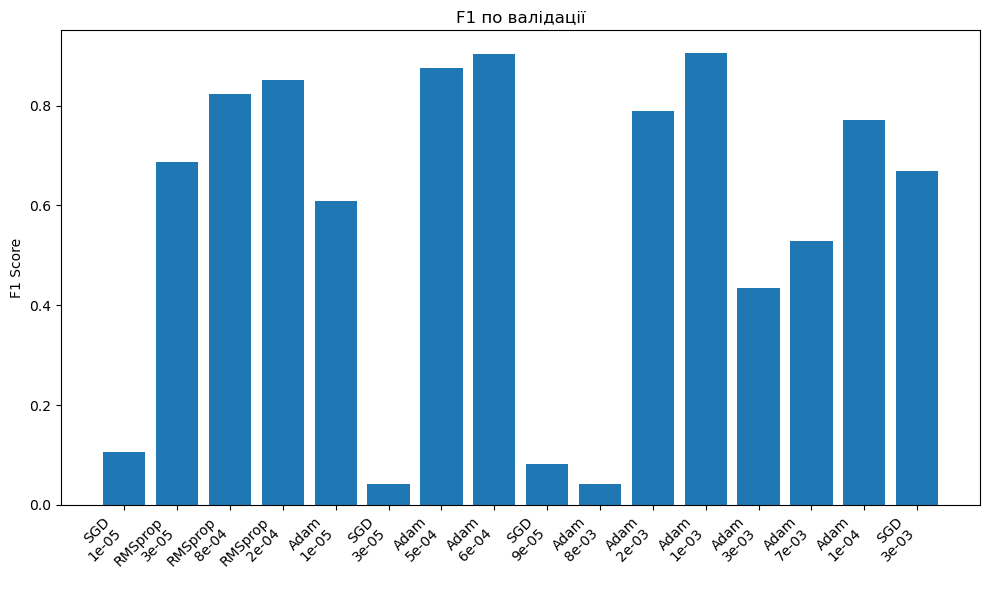

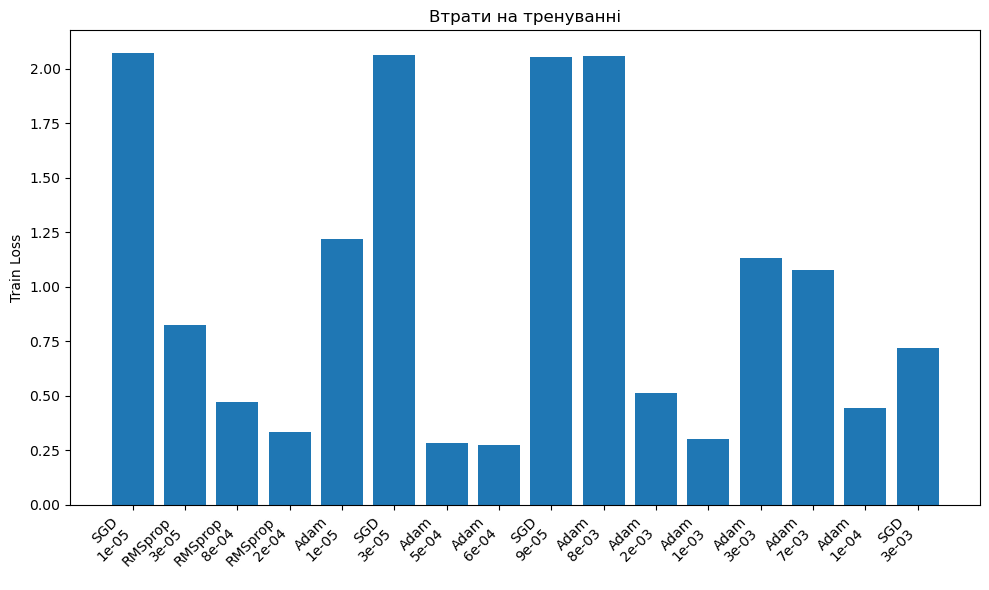

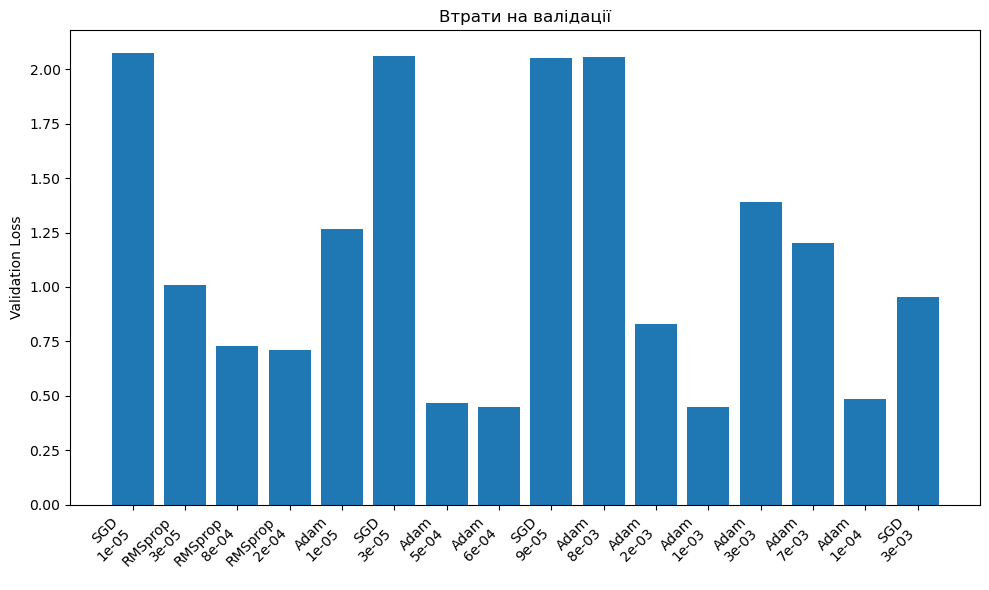

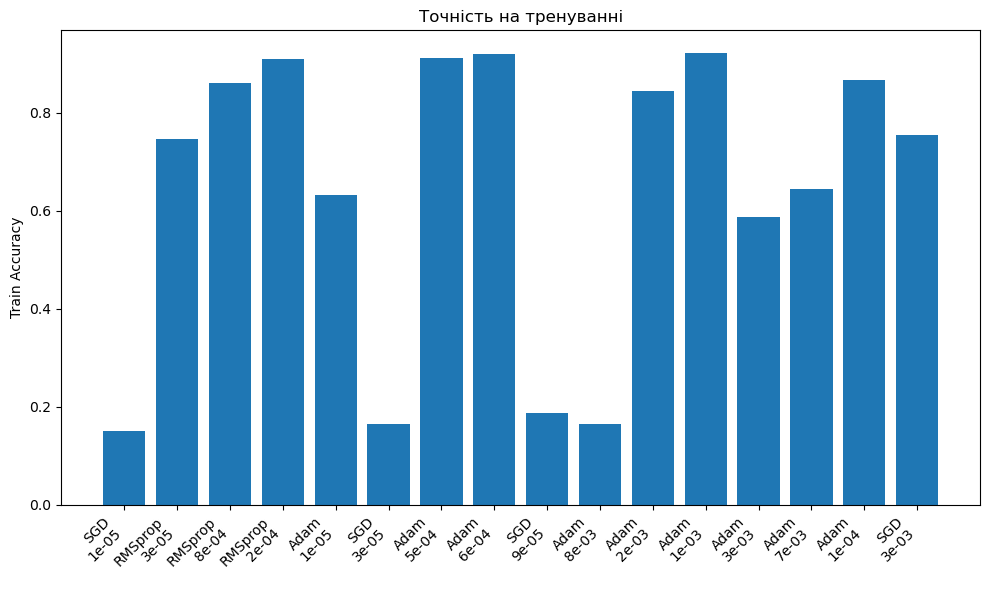

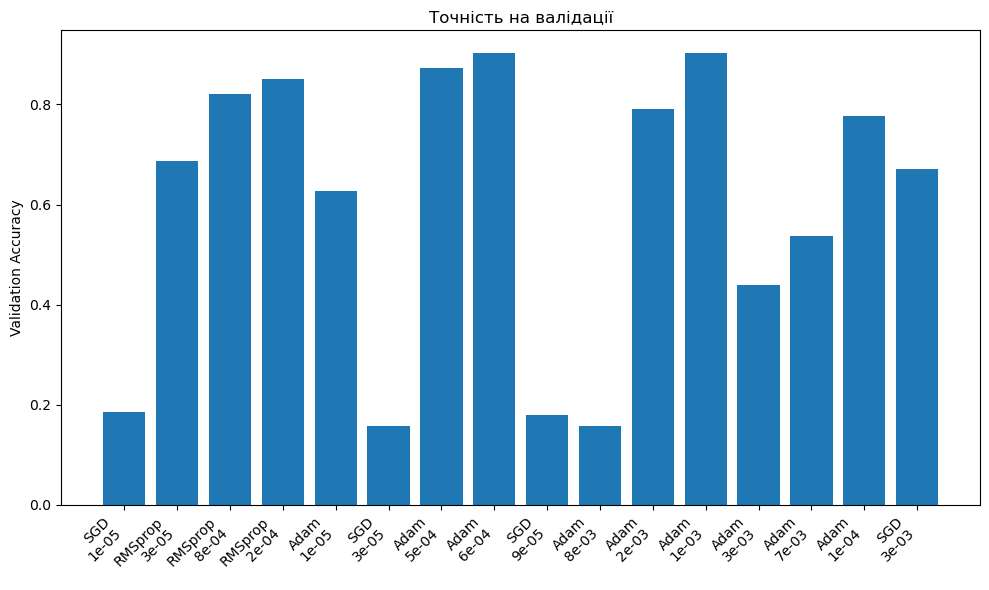

In [59]:
def plot_metric(metric_name, ylabel=None, title=None):
    values = []
    labels = []
    for t in study.trials:
        val = t.user_attrs.get(metric_name, None)
        if val is not None:
            values.append(val)
            lr = t.params.get("lr")
            opt = t.params.get("optimizer")
            labels.append(f"{opt}\n{lr:.0e}")
    
    plt.figure(figsize=(10, 6))
    plt.bar(labels, values)
    plt.ylabel(ylabel or metric_name)
    plt.title(title or metric_name)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    
metrics_to_plot = {
    "f1":          ("F1 Score", "F1 по валідації"),
    "train_loss":  ("Train Loss", "Втрати на тренуванні"),
    "val_loss":    ("Validation Loss", "Втрати на валідації"),
    "train_acc":   ("Train Accuracy", "Точність на тренуванні"),
    "val_acc":     ("Validation Accuracy", "Точність на валідації"),
}

for metric, (ylabel, title) in metrics_to_plot.items():
    plot_metric(metric_name=metric, ylabel=ylabel, title=title)


## Тренування моделі з найкращими параметрами
Було визначено що найефективніше використовувати {'lr': 0.0005566812682870772, 'optimizer': 'Adam'}

C:\Users\bogda\miniconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Епоха: 1/50

Епоха: 2/50

Епоха: 3/50

Епоха: 4/50

Епоха: 5/50

Епоха: 6/50

Епоха: 7/50

Епоха: 8/50

Епоха: 9/50

Епоха: 10/50

Епоха: 11/50

Епоха: 12/50

Епоха: 13/50

Епоха: 14/50

Епоха: 15/50

Епоха: 16/50

Епоха: 17/50

Епоха: 18/50

Епоха: 19/50

Епоха: 20/50

Епоха: 21/50

Епоха: 22/50

Епоха: 23/50

Епоха: 24/50

Епоха: 25/50

Епоха: 26/50

Епоха: 27/50

Епоха: 28/50

Епоха: 29/50

Епоха: 30/50

Епоха: 31/50

Епоха: 32/50

Епоха: 33/50

Епоха: 34/50

Епоха: 35/50

Епоха: 36/50

Епоха: 37/50

Епоха: 38/50

Епоха: 39/50

Епоха: 40/50

Епоха: 41/50

Епоха: 42/50

Епоха: 43/50

Епоха: 44/50

Епоха: 45/50

Епоха: 46/50

Епоха: 47/50

Епоха: 48/50

Епоха: 49/50

Епоха: 50/50

Модель збережено: cnn_f1.pt


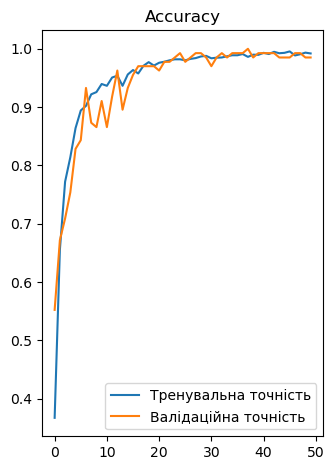

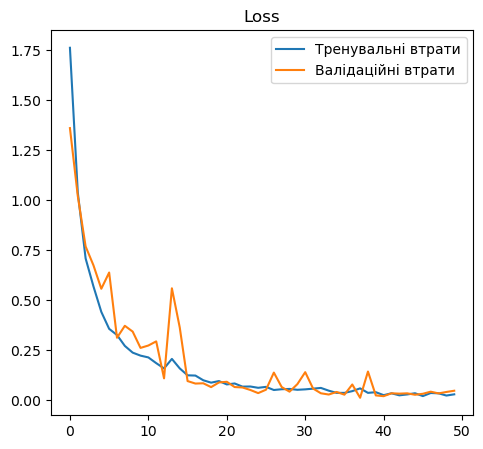

In [60]:
device = torch.device('cuda')

model = CnnF1().to(device)

epochs = 50
batch_size = 128
learning_rate = 0.0005
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss, val_loss, train_acc, val_acc = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs
)

plot_metrics(train_loss, val_loss, train_acc, val_acc)

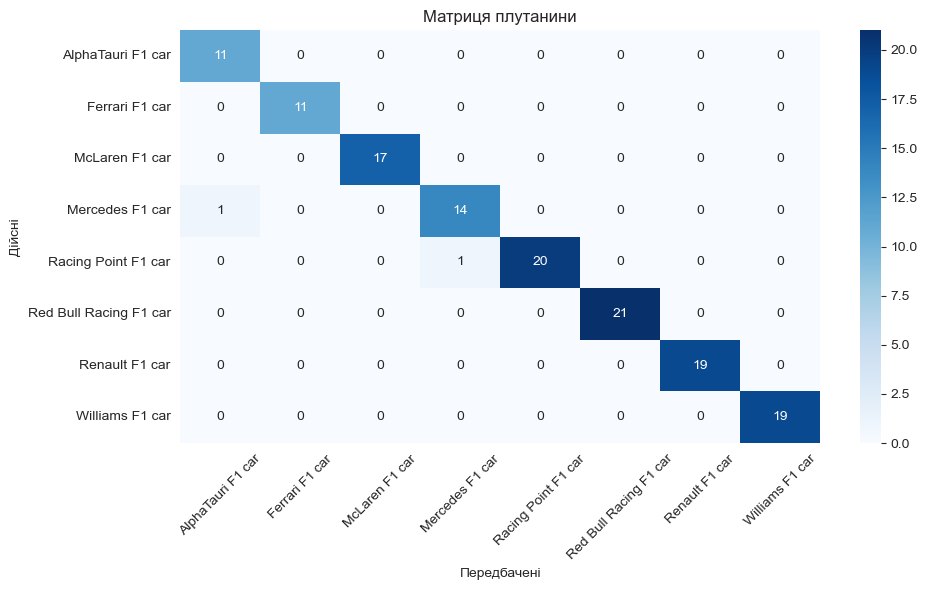


cnn_f1.pt
Точність: 0.9851
F1 Score: 0.9832


In [73]:
def evaluate_model(model_path, model_class, val_loader, device):
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    y_true = np.array(all_labels)
    y_pred = np.array(all_predictions)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Передбачені")
    plt.ylabel("Дійсні")
    plt.title("Матриця плутанини")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return acc, f1

final_model_path = "cnn_f1.pt"
acc, f1 = evaluate_model(final_model_path, CnnF1, val_loader, device)
print("\n" + final_model_path)
print(f"Точність: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")


## Використання моделі

C:\Users\bogda\miniconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


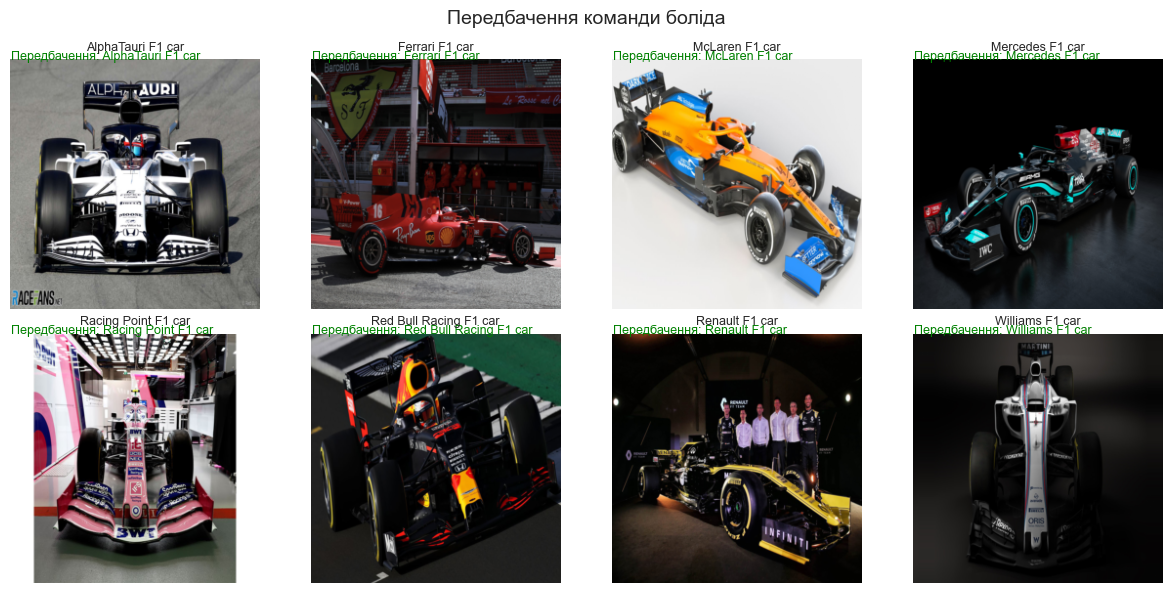

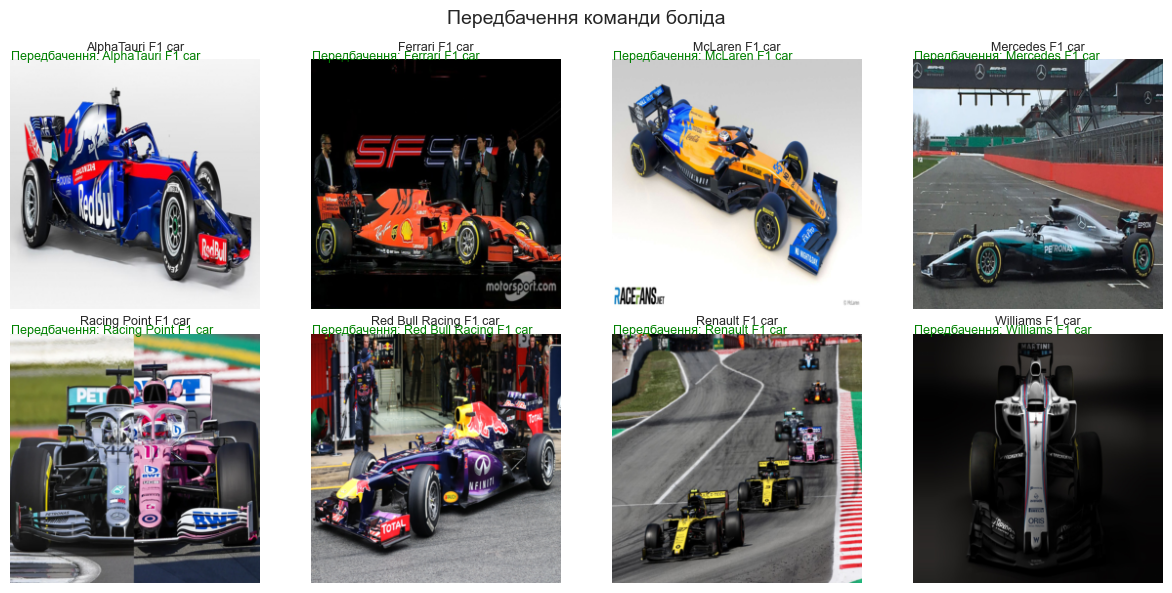

In [75]:
device = torch.device('cuda')

model.load_state_dict(torch.load("cnn_f1.pt"))
model.to(device)

show_predictions(model, test_loader, full_dataset.classes, device, title="Передбачення команди боліда")
show_predictions(model, test_loader, full_dataset.classes, device, title="Передбачення команди боліда")

## Transfer learning
MobilNetV2

In [80]:
transfer_model = models.mobilenet_v2(pretrained=True)
transfer_model.classifier[1] = nn.Linear(transfer_model.last_channel, 8)

for param in transfer_model.features.parameters():
    param.requires_grad = False
    
device = torch.device('cuda')
transfer_model = transfer_model.to(device)

device = torch.device('cuda')

epochs = 25
batch_size = 128
learning_rate = 0.0005
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transfer_model.parameters(), lr=learning_rate)

train_loss, val_loss, train_acc, val_acc = train_model(
    transfer_model, train_loader, val_loader, criterion, optimizer, epochs, "mobilnet_v2_f1.pt"
)



Епоха: 1/25

Епоха: 2/25

Епоха: 3/25

Епоха: 4/25

Епоха: 5/25

Епоха: 6/25

Епоха: 7/25

Епоха: 8/25

Епоха: 9/25

Епоха: 10/25

Епоха: 11/25

Епоха: 12/25

Епоха: 13/25

Епоха: 14/25

Епоха: 15/25

Епоха: 16/25

Епоха: 17/25

Епоха: 18/25

Епоха: 19/25

Епоха: 20/25

Епоха: 21/25

Епоха: 22/25

Епоха: 23/25

Епоха: 24/25

Епоха: 25/25

Модель збережено: mobilnet_v2_f1.pt


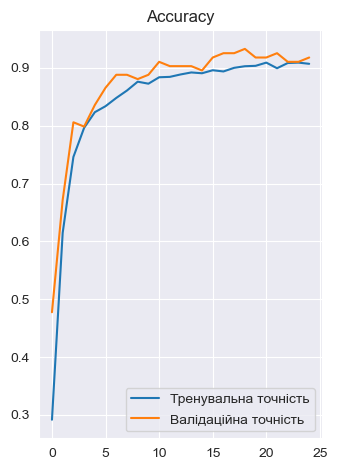

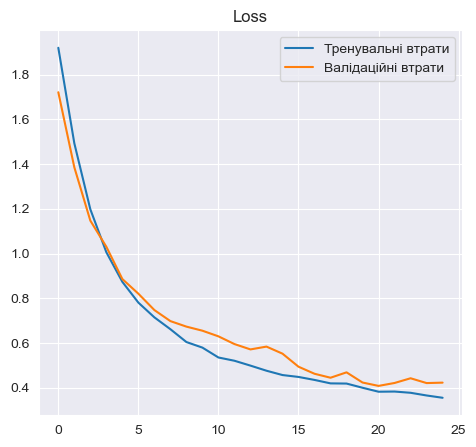

In [83]:
plot_metrics(train_loss, val_loss, train_acc, val_acc)

C:\Users\bogda\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


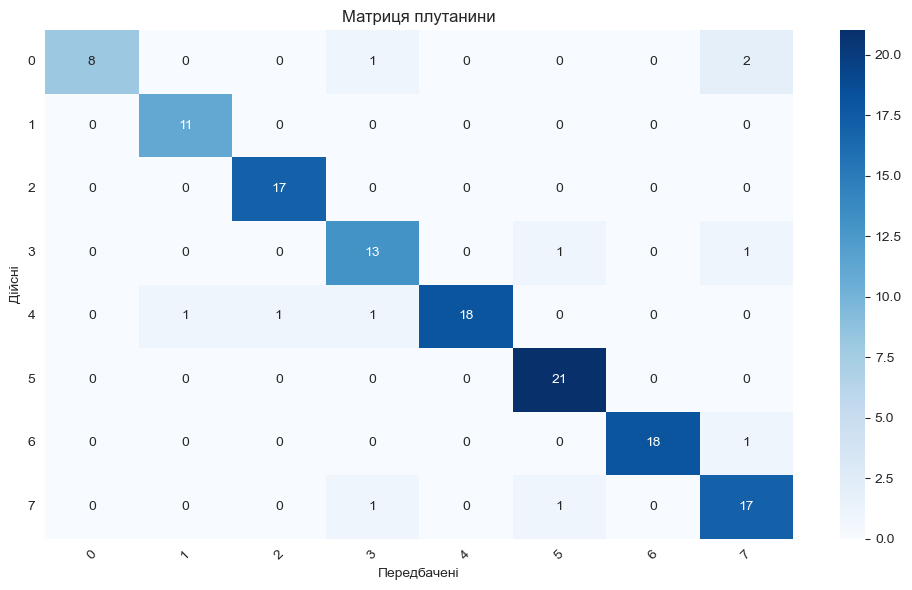


mobilnet_v2_f1.pt
Точність: 0.9179
F1 Score: 0.9137


In [86]:
def evaluate_model(model_path, model_class, val_loader, device, class_names=None):
    model = model_class(pretrained=False)  # важливо: pretrained=False
    model.classifier[1] = nn.Linear(model.last_channel, 8)  # 8 класів
    model = model.to(device)

    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    y_true = np.array(all_labels)
    y_pred = np.array(all_predictions)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names if class_names else range(8),
                yticklabels=class_names if class_names else range(8))
    plt.xlabel("Передбачені")
    plt.ylabel("Дійсні")
    plt.title("Матриця плутанини")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return acc, f1

transfer_model_path = "mobilnet_v2_f1.pt"
acc, f1 = evaluate_model(transfer_model_path, models.mobilenet_v2, val_loader, device)
print("\n" + transfer_model_path)
print(f"Точність: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")


C:\Users\bogda\miniconda3\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


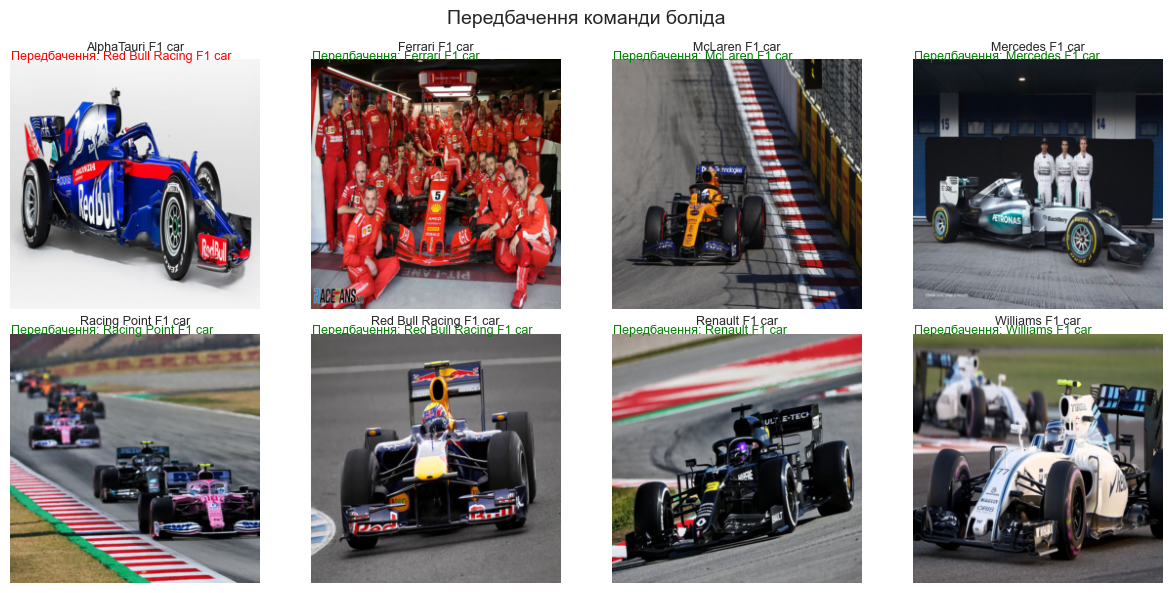

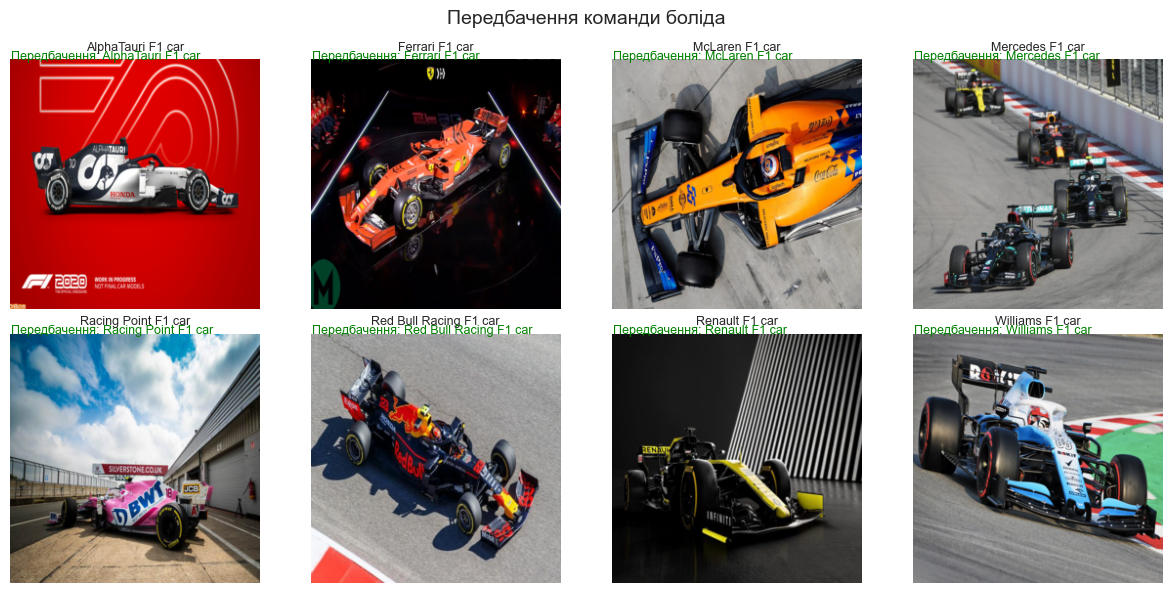

In [89]:
device = torch.device('cuda')

transfer_model.load_state_dict(torch.load("mobilnet_v2_f1.pt"))
transfer_model.to(device)

show_predictions(transfer_model, test_loader, full_dataset.classes, device, title="Передбачення команди боліда")
show_predictions(transfer_model, test_loader, full_dataset.classes, device, title="Передбачення команди боліда")